# Linear Regression: Finding the Best of the Best (Lines of Fit)
In this short notebook, we will demonstrate a simple, supervised technique for modeling the relationship between variables. Output in this case will be a linear equation, that is, one of the form mx + b. 

### A Little Housekeeping
We will first import all dependencies and set up our programming environment. 

In [501]:
# Reset the workspace, forcibly deleting all existing variables 
%reset -f

In [502]:
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.dates import DateFormatter

%matplotlib inline

### Importing the Data
Linear regression can be performed on any dataset, regardless of whether a clear upward or downward trend can be extrapolated. However, for the sake of demonstration, we will choose a set which does have a clear trend. 

Thus we'll be using a straightforward set of all-time historical stock data for Merck & Co (MRK). Our set includes years 1970 to 2020, during which time this stock has enjoyed a substantial increase in value. It was first listed on the Down Jones Industrial Average in 1979. Source: Yahoo Finance (https://finance.yahoo.com/quote/MRK/history?p=MRK)

We'll first import the data to a Pandas dataframe, preview the first handful of rows, and print a few statistics in order to get a feel for the data. 

Please note that the file, which is .csv format, will be saved in a directory named 'Data.'

In [503]:
df = pd.read_csv('Data/MRK.csv',
                parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1970-01-02,1.565972,1.565972,1.541667,1.545139,0.352593,475200
1,1970-01-05,1.545139,1.555556,1.531250,1.536458,0.350612,669600
2,1970-01-06,1.536458,1.548611,1.527778,1.548611,0.353385,568800
3,1970-01-07,1.548611,1.562500,1.531250,1.534722,0.350216,892800
4,1970-01-08,1.538194,1.555556,1.538194,1.545139,0.352593,496800


In [504]:
print('Dataframe shape:', df.shape)
print('Number of data examples:', df.shape[0])
print('Number of data features:', df.shape[1])
print('Number of dimensions:', df.ndim)

Dataframe shape: (12778, 7)
Number of data examples: 12778
Number of data features: 7
Number of dimensions: 2


Because it may be time costly to plot almost 13,000 points, we will take every fifth data point and omit all others. The overall trend and result of our regression analysis will end up essentially the same. 

In [505]:
df = df.iloc[::5, :] # Include every fifth row
print('Dataframe shape:', df.shape)
print('Number of data examples:', df.shape[0])
print('Number of data features:', df.shape[1])
print('Number of dimensions:', df.ndim)

Dataframe shape: (2556, 7)
Number of data examples: 2556
Number of data features: 7
Number of dimensions: 2


It can also be useful to display summary statistics. 

In [506]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2.556000e+03
mean,29.052236,29.352241,28.757661,29.068578,18.613251,7.044703e+06
std,25.784099,26.056528,25.520080,25.805094,20.460078,6.082407e+06
min,1.090278,1.097222,1.076389,1.076389,0.247066,2.232000e+05
25%,2.431424,2.457465,2.415799,2.436632,0.719148,2.892650e+06
50%,25.000000,25.187500,24.781250,24.937500,10.072225,5.536700e+06
75%,50.570000,51.070000,50.045626,50.679998,29.361950,9.522075e+06
max,92.812500,93.250000,91.269997,92.687500,90.172379,6.659160e+07


They say a picture is worth a thousand words. We'll now visualize the data using matplotlib, which can easily pull information from a Pandas dataframe. 

A small caveat is that the independent (x) and dependent (y) variables must be specified in order to use the df.plot() function. For that, it is trivially easy to simply look at the column headers displayed in df.head(). 

Another handy way to access these headers is by calling the columns attribute of the dataframe using df.columns, as seen below. 

In [507]:
df.columns # Displays column headers needed for plotting

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

We will plot stock close values from all time (1970 until present) with date as the independent variable. 

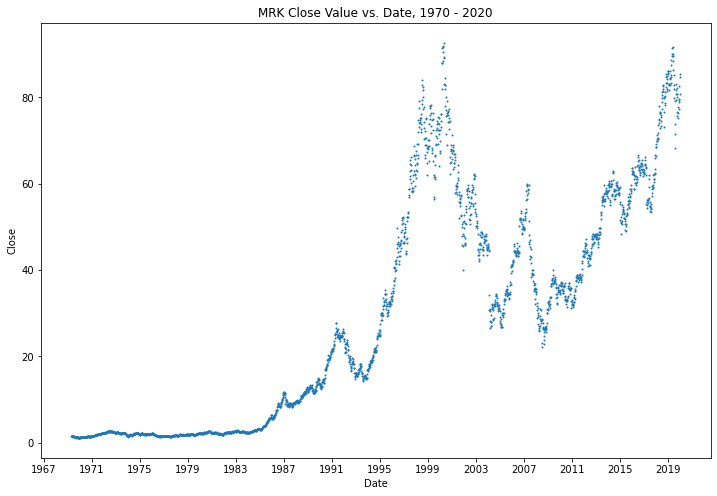

In [508]:
fig, ax = plt.subplots(figsize=(12,8), facecolor = 'white') # Sets plot size and color behind axes
ax.set_title('MRK Close Value vs. Date, 1970 - 2020') # Title

date_form = DateFormatter("%Y") # Formats x axis dates
ax.xaxis.set_major_formatter(date_form)

loc = plticker.MultipleLocator(base=365.0*4) # Set interval / frequency of x axis ticks
ax.xaxis.set_major_locator(loc) 

df.plot(kind = 'scatter', x = 'Date', y = 'Close', ax = ax, s = 1) # Plot data

plt.show() # Display plot

# Define Line Plotting Function

In [509]:
%matplotlib inline

def plot_line(x, weights):
    """
    Plots a line. 

    Args:
        x (type): 
        weights (type): 

    Returns:
        None

    """ 
    line = x @ weights
    plt.plot(line)
    plt.xlabel('Date')
    plt.ylabel('Close Value')
    plt.show()
    return line

# Define Cost Function

In [510]:
def compute_cost(x, y, weights):
    """
    Calculate the cost function. 
    
    To be run repeatedly as gradient descent executes.

    Args:
        x (type):
        y (type): 
        weights (type):

    Returns:
        J: cost, or the root mean squared error between hypotheses 
            (predictions) and actual values (y)
        
    """      
    num_samples = len(y)
    hypothesis = np.dot(x, weights)
    
    J = 1 / (2 * num_samples) * (sum(sum((hypothesis - y) ** 2)))
    
    return J

# Define Gradient Descent Function

In [511]:
def gradient_descent(x, y, weights, learning_rate, epochs):
    """
    Performs gradient descent. 

    Iteratively fit a regression line and calculate loss

    Args:
        x (type): 
        y (type): 
        empty_matrix (type):
        learning_rate (type):
        epochs (type):

    Returns:
        weights: description
        cost_history: description

    """   
    num_samples = len(y)
    cost_history = np.zeros([epochs, 1])
    
    for i in range(epochs):
        hypothesis = np.dot(x, weights)

        weight1 = weights[0] - learning_rate * (1/num_samples) * sum(hypothesis - y)
        weight2 = weights[1] - learning_rate * (1/num_samples) * sum((hypothesis - y) * x[:,1:2])
        
        weights[0] = weight1
        weights[1] = weight2
        
        print('SHAPE:', weights.shape)
        print('W1:', weights[0])
        print('W2:', weights[1])
        
        cost_history[i] = compute_cost(x, y, weights)
        # plot_line(x, weights)

    return hypothesis, weights, cost_history

# Main Program

First, we'll set the hyperparameters (learning rate, number of epochs) and parameters (weights) for the model. 

In [512]:
learning_rate = 0.10 # Also called 'alpha'
epochs = 100 # As desired
weights = np.zeros([2,1]) # weights[0] is intercept b; weights[1] is slope m

## Dealing with our 'Date' column
As you can see in the code below, the entries contained in the 'Date' column of the dataframe df are of the type pandas Timestamp. 

In [513]:
print('Date entry:', df['Date'][0])
print('Date entry type:', type(df['Date'][0]))

Date entry: 1970-01-02 00:00:00
Date entry type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


Linear regression methods do not handle this format well, so we will start by converting each of these timestamps into an ordinal value, that is, a number to represent the date and time. 

This is relatively straightforward to do using the toordinal function within the datetime module. Simply put, this function assigns every day from January 1st of the year 1 to December 31st of the 9,999th year its own number. 

In [514]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date']= df['Date'].map(dt.datetime.toordinal)

print('Type after conversion:', type(df['Date'][0]))

Type after conversion: <class 'numpy.int64'>


Now that everything has been nicely converted, we can define the variables that will be used in regression. 

In [515]:
x = df['Date'].to_numpy()
y = df['Close'].to_numpy()
m = len(x)

# Add a dimension to x and y to allow array multiplication later
x, y = np.expand_dims(x, axis = 1), np.expand_dims(y, axis = 1)

print('\nx.shape:', x.shape, 'type:', type(x))
print('y.shape:', y.shape, 'type:', type(y), '\n')

print('x: C O N V E R T E D   D A T E T I M E S \n', x)


x.shape: (2556, 1) type: <class 'numpy.ndarray'>
y.shape: (2556, 1) type: <class 'numpy.ndarray'> 

x: C O N V E R T E D   D A T E T I M E S 
 [[719164]
 [719171]
 [719178]
 ...
 [737647]
 [737654]
 [737661]]


## Sanity Check... 
Let's check, before continuing, that our conversion of datetimes to integers had the intended effect - that is, that original relationships in the data were preserved, and nothing was warped. 

We'll plot x vs. y for a quick visual comparison: 

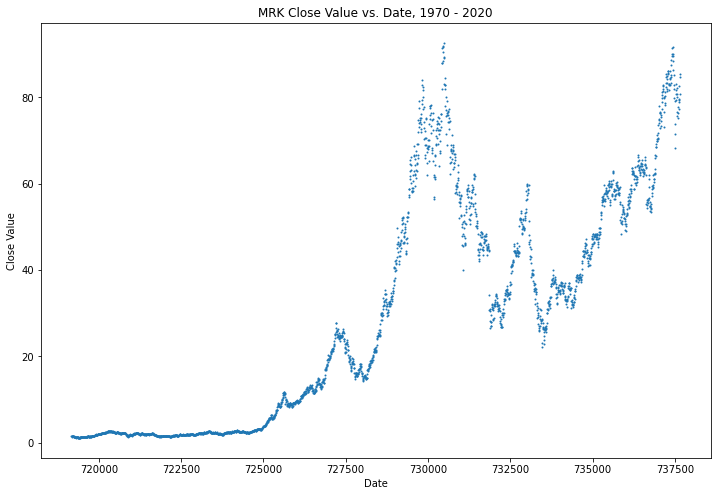

In [516]:
fig, ax = plt.subplots(figsize=(12,8), facecolor = 'white') # Sets plot size and color behind axes
ax.set_title('MRK Close Value vs. Date, 1970 - 2020') # Title
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.scatter(x, y, s=1)
plt.show()

Sure enough, everything looks at it should. Note that the date variable (displayed on the x axis) now displays as an oordinal number rather than as a year. This could be further formatted, but I've left it as-is to demonstrate the point. 

[[719164.]
 [719171.]
 [719178.]
 ...
 [737647.]
 [737654.]
 [737661.]]
(2556, 2)
Add ones to create X. X.shape: (2556, 2)
Weights.shape: (2, 1)
m: 2556
type(X): <class 'numpy.ndarray'>


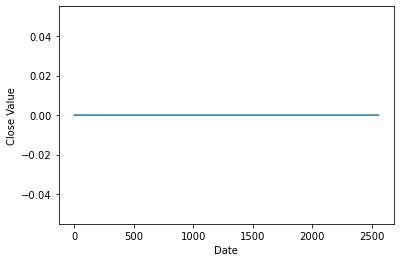

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [517]:
X = np.ones([m, 2])
X[:, 1:2] = x
print(X[:,1:2])
print(X.shape)

print('Add ones to create X. X.shape:', X.shape)
print('Weights.shape:', weights.shape)
print('m:', m)
print('type(X):', type(X))

print(plot_line(X, weights))

In [518]:
hypothesis, weights, cost_history = gradient_descent(X, y, weights, learning_rate, epochs)
hypothesis = np.dot(X, weights)
print('hypothesis.shape:', hypothesis.shape)

num_samples = len(y)
print('y.shape:', y.shape)

print('(hypothesis - y).shape:', (hypothesis - y).shape)
print('X[:,1]:', X[:,1].shape)
print('X[:,1:2]:', X[:,1:2].shape)
print('(hypothesis - y).shape:', (hypothesis - y).shape)

qq = ((hypothesis - y) * X[:,1:2])
print('qq.shape:', qq.shape)

ww = sum((hypothesis - y) * X[:,1:2])
print('sum((hypothesis - y) * X[:,1:2]):', ww)
print('ww.shape:', ww.shape)

weight1 = weights[0] - learning_rate * (1/num_samples) * sum(hypothesis - y)
weight2 = weights[1] - learning_rate * (1/num_samples) * sum((hypothesis - y) * X[:,1:2])

SHAPE: (2, 1)
W1: [2.90685781]
W2: [2129033.76950693]
SHAPE: (2, 1)
W1: [-1.55079319e+11]
W2: [-1.12966214e+17]
SHAPE: (2, 1)
W1: [8.22848555e+21]
W2: [5.99397046e+27]
SHAPE: (2, 1)
W1: [-4.36602215e+32]
W2: [-3.18039178e+38]
SHAPE: (2, 1)
W1: [2.31660484e+43]
W2: [1.68751113e+49]
SHAPE: (2, 1)
W1: [-1.22918707e+54]
W2: [-8.95390889e+59]
SHAPE: (2, 1)
W1: [6.52204825e+64]
W2: [4.75093069e+70]
SHAPE: (2, 1)
W1: [-3.46058907e+75]
W2: [-2.52083674e+81]
SHAPE: (2, 1)
W1: [1.83618339e+86]
W2: [1.33755221e+92]
SHAPE: (2, 1)
W1: [-9.74276169e+96]
W2: [-7.09703206e+102]
SHAPE: (2, 1)
W1: [5.16949481e+107]
W2: [3.76567462e+113]
SHAPE: (2, 1)
W1: [-2.74292623e+118]
W2: [-1.99806133e+124]
SHAPE: (2, 1)
W1: [1.45539257e+129]
W2: [1.06016836e+135]
SHAPE: (2, 1)
W1: [-7.72229123e+139]
W2: [-5.62523751e+145]
SHAPE: (2, 1)
W1: [4.0974362e+150]
W2: [2.98474263e+156]
SHAPE: (2, 1)
W1: [-2.17409353e+161]
W2: [-1.58369998e+167]
SHAPE: (2, 1)
W1: [1.15357078e+172]
W2: [8.40308848e+177]
SHAPE: (2, 1)
W1: [-

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in add
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in subtract


In [519]:
z = (hypothesis - y)*X[:,1]
print(type(z))
print(z.shape)

<class 'numpy.ndarray'>
(2556, 2556)


In [520]:
hypothesis, weights, cost_history = gradient_descent(X, y, weights, learning_rate, epochs)
print(hypothesis, weights, cost_history)

SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
W1: [nan]
W2: [nan]
SHAPE: (2, 1)
